# Pipeline

## 1. Blocks cutting

### 1.1. Fetching data from OpenStreetMap. 
The step can be skipped, if the data already exists.

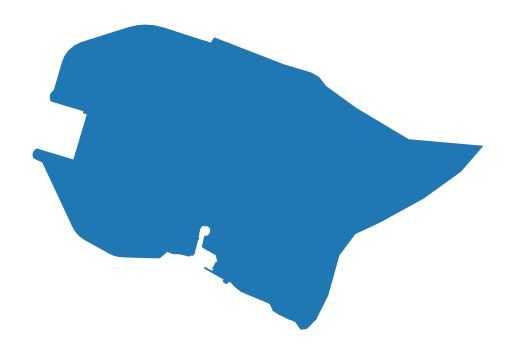

In [1]:
import osmnx as ox

boundaries = ox.geocode_to_gdf('Санкт-Петербург, Василеостровский район')
boundaries.plot().set_axis_off()

In [2]:
bc_tags = {
    'roads': {
      "highway": ["construction","crossing","living_street","motorway","motorway_link","motorway_junction","pedestrian","primary","primary_link","raceway","residential","road","secondary","secondary_link","services","tertiary","tertiary_link","track","trunk","trunk_link","turning_circle","turning_loop","unclassified",],
      "service": ["living_street", "emergency_access"]
    },
    'railways': {
      "railway": "rail"
    },
    'water': {
      'riverbank':True,
      'reservoir':True,
      'basin':True,
      'dock':True,
      'canal':True,
      'pond':True,
      'natural':['water','bay'],
      'waterway':['river','canal','ditch'],
      'landuse':'basin',
      'water': 'lake'
    }
}

In [3]:
water = ox.features_from_polygon(boundaries.union_all(), bc_tags['water'])
roads = ox.features_from_polygon(boundaries.union_all(), bc_tags['roads'])
railways = ox.features_from_polygon(boundaries.union_all(), bc_tags['railways'])

In [4]:
water = water[water.geom_type.isin(['Polygon', 'MultiPolygon', 'LineString', 'MultiLineString'])].copy()
roads = roads[roads.geom_type.isin(['LineString', 'MultiLineString'])].copy()
railways = railways[railways.geom_type.isin(['LineString', 'MultiLineString'])].copy()

In [5]:
crs = boundaries.estimate_utm_crs()

for gdf in [water, roads, railways, boundaries]:
  gdf.to_crs(crs, inplace=True)

### 1.2. Preprocessing input geometry

The step can be skipped if input geometries are already sorted as lines, polygons and boundary.

In [6]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

lines, polygons = preprocess_urban_objects(roads, railways, water)

2025-05-16 17:23:19.636 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:36 - Checking roads schema
2025-05-16 17:23:19.674 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:42 - Checking railways schema
2025-05-16 17:23:19.685 | INFO     | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:48 - Checking water schema


### 1.3. Cutting urban blocks

In [7]:
blocks = cut_urban_blocks(boundaries, lines, polygons)

2025-05-16 17:23:19.716 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:20 - Checking boundaries schema
2025-05-16 17:23:19.726 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:24 - Checking line objects schema
2025-05-16 17:23:19.741 | INFO     | blocksnet.blocks.cutting.processing.core:wrapper:30 - Checking polygon objects schema
2025-05-16 17:23:19.756 | INFO     | blocksnet.blocks.cutting.processing.core:_exclude_polygons:45 - Excluding polygon objects from blocks
2025-05-16 17:23:20.197 | INFO     | blocksnet.blocks.cutting.processing.core:_get_enclosures:51 - Setting up enclosures
2025-05-16 17:23:20.235 | INFO     | blocksnet.blocks.cutting.processing.core:_fill_holes:68 - Filling holes inside the blocks
2025-05-16 17:23:20.263 | INFO     | blocksnet.blocks.cutting.processing.core:_filter_overlapping:78 - Filtering overlapping geometries
2025-05-16 17:23:20.313 | SUCCESS  | blocksnet.blocks.cutting.processing.core:cut_urban_blocks:119 - Blocks are succ

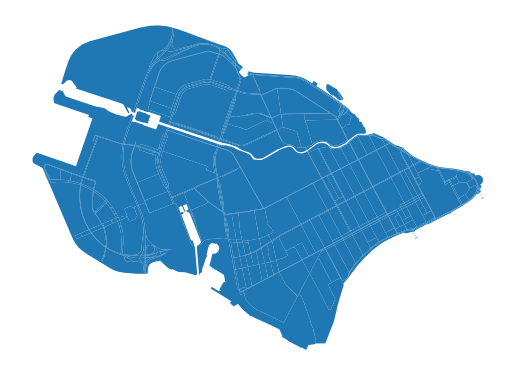

In [8]:
blocks.plot().set_axis_off()

## 2. Land use assignment

### 2.1. Fetching data from OpenStreetMap

The step can be skipped if functional zones layer is already obtained via goverment sources.

In [9]:
import osmnx as ox

functional_zones = ox.features_from_polygon(boundaries.to_crs(4326).union_all(), tags={'landuse': True})

In [10]:
functional_zones = functional_zones.reset_index(drop=True)[['geometry','landuse']].rename(columns={'landuse': 'functional_zone'})
functional_zones = functional_zones.to_crs(crs)
functional_zones.head()

,geometry,functional_zone
0,"POLYGON ((345659.049 6646239.362, 345672.29 66...",commercial
1,"POLYGON ((346755.014 6647579.789, 346728.91 66...",industrial
2,"POLYGON ((345964.693 6646155.952, 346283.885 6...",industrial
3,"POLYGON ((345753.722 6648393.897, 345900.252 6...",cemetery
4,"POLYGON ((345900.252 6648481.707, 345896.076 6...",garages


### 2.2. Specifying rules

Rules define how `functional_zone` column will be mapped into `LandUse`.

In [11]:
from blocksnet.enums import LandUse

rules = {
  'commercial': LandUse.BUSINESS,
  'industrial': LandUse.INDUSTRIAL,
  'cemetery': LandUse.SPECIAL,
  'garages': LandUse.INDUSTRIAL,
  'residential': LandUse.RESIDENTIAL,
  'retail': LandUse.BUSINESS,
  'grass': LandUse.RECREATION,
  'farmland': LandUse.AGRICULTURE,
  'construction': LandUse.SPECIAL,
  'brownfield': LandUse.INDUSTRIAL,
  'forest': LandUse.RECREATION,
  'recreation_ground': LandUse.RECREATION,
  'religious': LandUse.SPECIAL,
  'flowerbed': LandUse.RECREATION,
  'military': LandUse.SPECIAL,
  'landfill': LandUse.TRANSPORT
}

### 2.3. Assignment

In [12]:
from blocksnet.blocks.assignment import assign_land_use

blocks = assign_land_use(blocks, functional_zones.reset_index(drop=True).rename(columns={'landuse': 'functional_zone'}), rules)

2025-05-16 17:23:20.914 | INFO     | blocksnet.blocks.assignment.core:assign_land_use:44 - Overlaying geometries
2025-05-16 17:23:21.022 | SUCCESS  | blocksnet.blocks.assignment.core:assign_land_use:55 - Shares calculated


In [13]:
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((345747.414 6646456.191, 345751.077 6...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
1,"POLYGON ((345751.077 6646449.404, 345747.414 6...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
2,"POLYGON ((345047.432 6648157.204, 345028.835 6...",0.496234,0.093738,0.115348,0.0,0.0,0.000000,0.0,LandUse.RESIDENTIAL,0.496234
3,"POLYGON ((344951.065 6648110.08, 344977.865 66...",0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,None,NaN
4,"POLYGON ((346686.09 6647227.682, 346691.412 66...",0.173093,0.116007,0.005135,0.0,0.0,0.167767,0.0,LandUse.RESIDENTIAL,0.173093


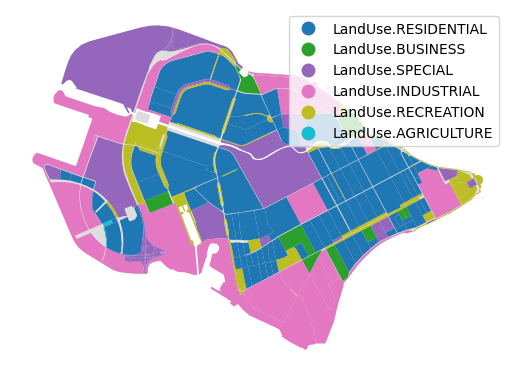

In [14]:
ax = blocks.plot(color='#ddd')
blocks.plot(column='land_use', legend=True, ax=ax).set_axis_off()

## 3. Accessibility matrix calculation

There are few ways to define spatial relations between urban blocks:
- **Accessibility matrix** -- `n^2` matrix that defines travel time between urban blocks' centroids in minutes.
- **Distance matrix** -- `n^2` matrix that defines euclidian distance between urban blocks' centroids in meters.
- **Adjacency graph** -- graph with `n` nodes. Each edge of this graph indicates spatial adjacency of two urban blocks.

In this example the **accessibility matrix** will be calculated using `IduEdu` library.

### 3.1. Intermodal graph construction

There are few types of city graphs to model city network:
- **walk** -- pedestrian network.
- **drive** -- personal transport network.
- **intermodal** -- pedestrian and public transport network.

In this example **intermodal** graph will be constructed, but overall it depends on one's research.

In [15]:
from blocksnet.relations import get_accessibility_graph

graph = get_accessibility_graph(boundaries, 'intermodal')

2025-05-16 17:23:24.976 | WARNING  | blocksnet.relations.accessibility.graph:get_accessibility_graph:14 - CRS do not match IDUEDU required crs. Reprojecting
2025-05-16 17:23:24.978 | INFO     | iduedu.modules.drive_walk_builder:get_walk_graph:217 - Downloading walk graph from OSM, it may take a while for large territory ...


Parsing public transport routes:   0%|          | 0/61 [00:00<?, ?it/s]

Calculating the weights of the walk graph:   0%|          | 0/49364 [00:00<?, ?it/s]

2025-05-16 17:23:52.489 | INFO     | iduedu.modules.pt_walk_joiner:join_pt_walk_graph:51 - Composing intermodal graph...
2025-05-16 17:23:55.362 | WARNING  | iduedu.utils.utils:remove_weakly_connected_nodes:37 - Removing 555 nodes that form 269 trap components. These are groups where you can enter but can't exit (or vice versa). Keeping the largest strongly connected component (20350 nodes).


### 3.2. Calculating the accessibility matrix

In [16]:
from blocksnet.relations import calculate_accessibility_matrix

acc_mx = calculate_accessibility_matrix(blocks, graph)

In [17]:
acc_mx.head()

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,574,575,576,577,578,579,580,581,582,583
0,0.000000,0.623535,13.679688,9.679688,7.523438,11.148438,18.71875,15.585938,17.484375,14.890625,...,25.015625,13.789062,12.218750,13.820312,15.375000,14.859375,16.125000,21.109375,12.625000,20.078125
1,0.623535,0.000000,13.531250,9.531250,7.371094,10.992188,18.56250,15.437500,17.328125,14.742188,...,24.859375,13.640625,12.070312,13.664062,15.218750,14.703125,15.976562,20.953125,12.468750,19.921875
2,13.398438,13.250000,0.000000,5.152344,17.250000,16.937500,19.37500,13.445312,15.343750,12.750000,...,19.453125,11.640625,9.250000,11.679688,9.804688,9.281250,10.554688,17.046875,21.250000,15.898438
3,11.750000,11.593750,5.152344,0.000000,14.585938,14.187500,16.68750,10.742188,12.648438,10.046875,...,18.562500,8.460938,7.371094,8.843750,8.921875,8.398438,9.671875,16.171875,19.250000,15.015625
4,7.953125,8.296875,17.281250,13.273438,0.000000,6.140625,16.90625,16.062500,15.890625,17.515625,...,28.625000,17.390625,15.812500,17.421875,18.984375,18.453125,19.734375,24.718750,15.265625,23.687500


## 4. Buildings aggregation

Buildings define the urban environment parameters in different blocks. For some blocksnet methods only population can be used, but overall the building is defined via:

- `population : float`
- `footprint_area : float` -- building's base area
- `number_of_floors : float`
- `build_floor_area : float` -- sum area of each building floor
- `is_living : bool`
- `living_area : float` -- area defined for residents
- `non_living_area : float` -- area not defined to live in

Some of these parameters may be optional, depends on what one already has.

### 4.1. Fetching data from OpenStreetMap

The step can be skipped if the data already obtained from any available source.

In [18]:
buildings = ox.features_from_polygon(boundaries.to_crs(4326).union_all(), tags={'building': True}).reset_index(drop=True).to_crs(crs)

#### 4.1.1. `is_living`

In [19]:
is_living_tags = ['residential', 'house', 'apartments', 'detached', 'terrace', 'dormitory']
buildings['is_living'] = buildings['building'].apply(lambda b : b in is_living_tags)

#### 4.1.2. `number_of_floors`

In [20]:
import pandas as pd

buildings['number_of_floors'] = pd.to_numeric(buildings['building:levels'], errors='coerce')

### 4.2. Imputing missing data

In [21]:
from blocksnet.preprocessing.imputing import impute_buildings

buildings = impute_buildings(buildings, default_living_demand=30)

2025-05-16 17:24:06.880 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column footprint_area not found and will be initialized as None
2025-05-16 17:24:06.881 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column build_floor_area not found and will be initialized as None
2025-05-16 17:24:06.881 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column living_area not found and will be initialized as None
2025-05-16 17:24:06.882 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column non_living_area not found and will be initialized as None
2025-05-16 17:24:06.882 | WARNING  | blocksnet.preprocessing.imputing.buildings.schemas:_before_validate:21 - Column population not found and will be initialized as None


In [22]:
buildings.sample(5)

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population
651,"POLYGON ((345707.15 6647277.813, 345713.366 66...",True,5.0,1508.646392,7543.231961,6788.908765,754.323196,226.0
3767,"POLYGON ((347982.577 6648704.74, 347978.314 66...",False,1.0,165.940125,165.940125,0.000000,165.940125,NaN
124,"POLYGON ((347167.301 6648613.826, 347159.307 6...",False,1.0,2809.517622,2809.517622,0.000000,2809.517622,NaN
1126,"POLYGON ((346209.426 6646888, 346222.815 66468...",False,1.0,364.041807,364.041807,0.000000,364.041807,NaN
1965,"POLYGON ((347965.1 6648464.713, 347967.454 664...",False,1.0,56.805168,56.805168,0.000000,56.805168,NaN


In [23]:
buildings.population.sum()

np.float64(271251.0)

### 4.3. Aggregating buildings within blocks

In [24]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings_blocks = aggregate_objects(blocks, buildings)[0]

2025-05-16 17:24:07.003 | INFO     | blocksnet.blocks.aggregation.core:_preprocess_input:12 - Preprocessing input
2025-05-16 17:24:07.014 | INFO     | blocksnet.blocks.aggregation.core:aggregate_objects:41 - Aggregating objects


In [25]:
buildings_blocks.head()

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population,objects_count
0,"POLYGON ((345747.414 6646456.191, 345751.077 6...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,"POLYGON ((345751.077 6646449.404, 345747.414 6...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,"POLYGON ((345047.432 6648157.204, 345028.835 6...",18.0,287.0,67273.384879,386154.823127,295058.918381,91095.904746,9827.0,72.0
3,"POLYGON ((344951.065 6648110.08, 344977.865 66...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,"POLYGON ((346686.09 6647227.682, 346691.412 66...",1.0,32.0,3411.837763,54589.404201,24939.758056,29649.646145,831.0,2.0


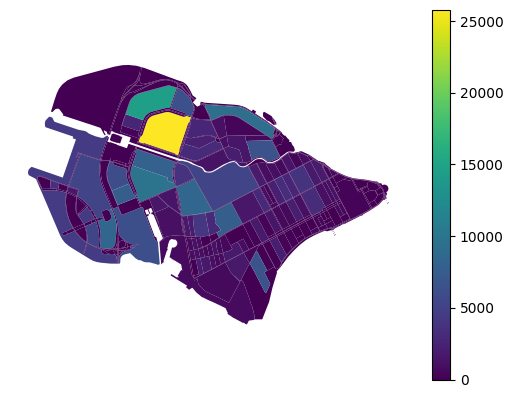

In [26]:
buildings_blocks.plot('population', legend=True).set_axis_off()

## 5. Services aggregation

### 5.1. Fetching data from OpenStreetMap

And once again: if one already has the required data, the step can be skipped.

In [35]:
schools = ox.features_from_polygon(boundaries.to_crs(4326).union_all(), tags={'amenity': 'school'}).reset_index(drop=True).to_crs(crs)

### 5.2. Imputing missing data

In [36]:
from blocksnet.preprocessing.imputing import impute_services

schools = impute_services(schools, 'school')

In [37]:
schools.head()

,geometry,capacity
0,POINT (345500.447 6647564.184),250.0
1,POINT (348138.425 6647505.876),250.0
2,POINT (348050.437 6648161.823),250.0
3,POINT (346370.983 6648934.02),250.0
4,POINT (348061.507 6648770.774),250.0


### 5.3. Aggregating services within blocks

In [38]:
schools_blocks = aggregate_objects(blocks, schools)[0]

2025-05-16 17:28:03.882 | INFO     | blocksnet.blocks.aggregation.core:_preprocess_input:12 - Preprocessing input
2025-05-16 17:28:03.884 | INFO     | blocksnet.blocks.aggregation.core:aggregate_objects:41 - Aggregating objects


In [39]:
schools_blocks.head()

,geometry,capacity,objects_count
0,"POLYGON ((345747.414 6646456.191, 345751.077 6...",0.0,0.0
1,"POLYGON ((345751.077 6646449.404, 345747.414 6...",0.0,0.0
2,"POLYGON ((345047.432 6648157.204, 345028.835 6...",750.0,3.0
3,"POLYGON ((344951.065 6648110.08, 344977.865 66...",0.0,0.0
4,"POLYGON ((346686.09 6647227.682, 346691.412 66...",0.0,0.0


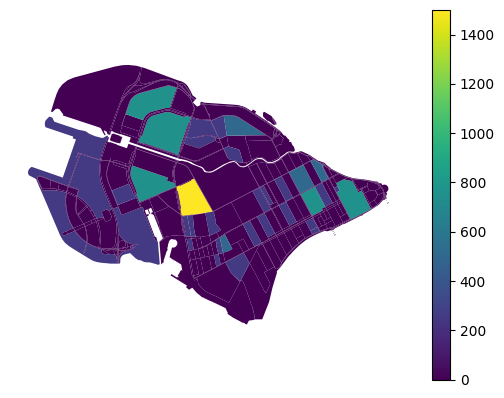

In [40]:
schools_blocks.plot('capacity', legend=True).set_axis_off()

## 6. Results

Using the methods above the following data can be obtained:

- **Urban blocks layer** -- `GeoDataFrame` of urban blocks within the modeled territory (city).
- **Land use assignment layer** -- the assignment of current land use according to any source of functional zones data.
- **Accessibility matrix** -- `DataFrame` `n*n` matrix of accessibility values in minutes between each pair of urban blocks.
- **Buildings aggregation layer** -- the aggregation of buildings parameters within urban blocks.
- **Services aggregation layer** -- the aggregation of services parameters within urban blocks.

It's important to mention that any type of data can be aggregated within city blocks depending on the task.

## 7. Use examples

### 7.1. Competitive provision

In [43]:
df = buildings_blocks[['population']].join(schools_blocks[['capacity']])
df.head()

,population,capacity
0,0.0,0.0
1,0.0,0.0
2,9827.0,750.0
3,0.0,0.0
4,831.0,0.0


In [49]:
from blocksnet.config import service_types_config

_, demand, accessibility = service_types_config['school'].values()
demand, accessibility

(120, 15)

In [51]:
from blocksnet.analysis.provision import competitive_provision

prov_df, links_df = competitive_provision(df, acc_mx, accessibility, demand)

2025-05-16 18:07:05.900 | INFO     | blocksnet.analysis.provision.competivive.core:_initialize_provision_df:29 - Initializing provision DataFrame
2025-05-16 18:07:05.901 | WARNING  | blocksnet.analysis.provision.competivive.core:_initialize_provision_df:33 - No demand in columns. Imputing using population column and demand parameter
2025-05-16 18:07:05.910 | INFO     | blocksnet.analysis.provision.competivive.core:_supply_self:56 - Supplying blocks with own capacities
2025-05-16 18:07:05.918 | INFO     | blocksnet.analysis.provision.competivive.core:competitive_provision:173 - Setting and solving LP problems until max depth or break condition reached
100%|██████████| 1/1 [00:00<00:00, 11.40it/s]
2025-05-16 18:07:06.009 | SUCCESS  | blocksnet.analysis.provision.competivive.core:competitive_provision:186 - Provision assessment finished


In [57]:
prov_df.head()

,demand,capacity,demand_left,demand_within,demand_without,capacity_left,capacity_within,capacity_without,provision_strong,provision_weak
0,0,0,0,0,0,0,0,0,NaN,NaN
1,0,0,0,0,0,0,0,0,NaN,NaN
2,1179,750,429,750,0,0,0,0,0.636132,0.636132
3,0,0,0,0,0,0,0,0,NaN,NaN
4,100,0,100,0,0,0,0,0,0.000000,0.000000


In [58]:
links_df.head()

value
source target       
21     390      16.0
23     11      121.0
31     114     154.0
       201      55.0
59     213      76.0

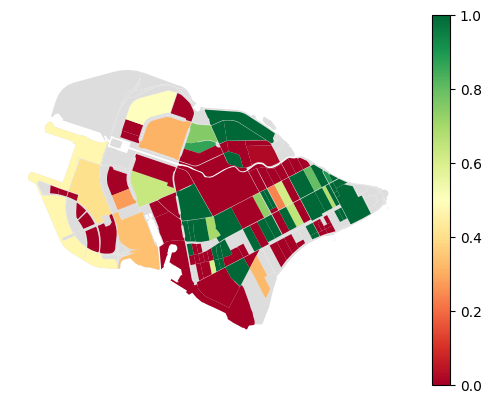

In [56]:
ax = blocks.plot(color='#ddd')
blocks.join(prov_df).plot('provision_strong', ax=ax, cmap='RdYlGn', vmin=0, vmax=1, legend=True)
ax.set_axis_off()

### 7.2. Morphotypes

In [63]:
from blocksnet.analysis.indicators import calculate_density_indicators

buildings_blocks['site_area'] = buildings_blocks.area
density_df = calculate_density_indicators(buildings_blocks)
density_df.head()

,site_area,footprint_area,build_floor_area,living_area,non_living_area,fsi,gsi,mxi,l,osr,share_living,share_non_living
0,356.518194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,inf,NaN,NaN
1,410.939744,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,inf,NaN,NaN
2,364393.913217,67273.384879,386154.823127,295058.918381,91095.904746,1.059718,0.184617,0.764095,5.740083,0.769434,4.385968,1.354115
3,4135.809669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,inf,NaN,NaN
4,31474.102302,3411.837763,54589.404201,24939.758056,29649.646145,1.734423,0.108401,0.456861,16.000000,0.514061,7.309773,8.690227


#### 7.2.1. Spacematrix morphotypes

In [65]:
from blocksnet.analysis.morphotypes import get_spacematrix_morphotypes

spacematrix_df, spacematrix_clusters = get_spacematrix_morphotypes(density_df)

In [72]:
spacematrix_df.head()

,l,fsi,mxi,cluster,morphotype
0,0.000000,0.000000,0.000000,NaN,NaN
1,0.000000,0.000000,0.000000,NaN,NaN
2,5.740083,1.059718,0.764095,7.0,mid-rise residential
3,0.000000,0.000000,0.000000,NaN,NaN
4,16.000000,1.734423,0.456861,2.0,high-rise residential


In [73]:
spacematrix_clusters.head()

,l,fsi,mxi,l_interpretation,fsi_interpretation,mxi_interpretation,morphotype
cluster,,,,,,,
0,2.934850,1.154953,0.000000,low-rise,None,non-residential,low-rise non-residential
1,5.326747,1.748314,0.889017,mid-rise,None,residential,mid-rise residential
2,15.348045,1.679297,0.883299,high-rise,None,residential,high-rise residential
3,1.000000,0.035799,0.000000,low-rise,low-density,non-residential,low-rise low-density non-residential
4,3.450012,1.487791,0.568041,mid-rise,None,residential,mid-rise residential


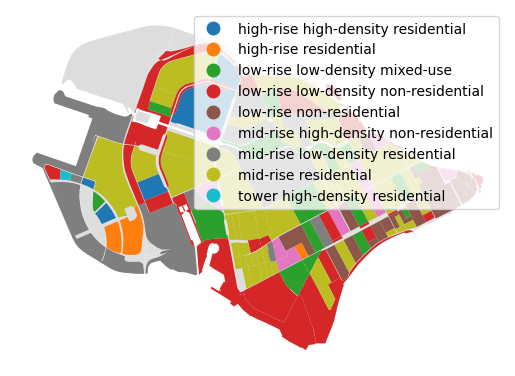

In [71]:
ax = blocks.plot(color='#ddd')
blocks.join(spacematrix_df).plot('morphotype', legend=True, ax=ax)
ax.set_axis_off()

#### 7.2.2. Strelka morphotypes

In [74]:
from blocksnet.analysis.morphotypes import get_strelka_morphotypes

strelka_df = get_strelka_morphotypes(density_df)

In [75]:
strelka_df.head()

,l,fsi,mxi,morphotype
0,0.000000,0.000000,0.000000,NaN
1,0.000000,0.000000,0.000000,NaN
2,5.740083,1.059718,0.764095,mid-rise
3,0.000000,0.000000,0.000000,NaN
4,16.000000,1.734423,0.456861,high-rise modern microdistrict


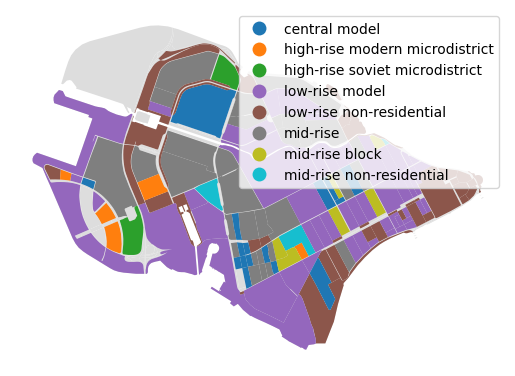

In [76]:
ax = blocks.plot(color='#ddd')
blocks.join(strelka_df).plot('morphotype', legend=True, ax=ax)
ax.set_axis_off()

### 7.3. Accessibility analysis

In [85]:
from blocksnet.analysis.accessibility import area_accessibility

area_acc = area_accessibility(acc_mx, buildings_blocks)

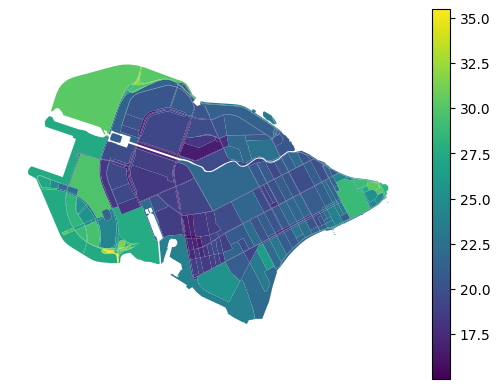

In [86]:
blocks.join(area_acc).plot('area_accessibility', legend=True).set_axis_off()